## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here

            # Вход: 784 (28*28) -> Скрытый слой 1: 512 -> Скрытый слой 2: 128 -> Выход: 10
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
       BatchNorm1d-4                  [-1, 512]           1,024
            Linear-5                  [-1, 128]          65,664
              ReLU-6                  [-1, 128]               0
       BatchNorm1d-7                  [-1, 128]             256
            Linear-8                   [-1, 10]           1,290
Total params: 470,154
Trainable params: 470,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.82
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Your experiments, training and validation loops here
loss_func = nn.CrossEntropyLoss()
num_epochs = 30 # Обычно хватает 15-20, берем с запасом

for epoch in range(num_epochs):
    # тренировка
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        opt.zero_grad()
        outputs = model(images)   # Прямой проход (Forward)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        running_loss += loss.item()

    #  оценка
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) #  индекс класса с макс. вероятностью
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {accuracy:.4f}')

    # Проверка условия задачи
    if accuracy >= 0.885:
        print(f"Target accuracy reached: {accuracy:.4f}")



Epoch [1/30], Loss: 0.4432, Test Accuracy: 0.8425
Epoch [2/30], Loss: 0.3569, Test Accuracy: 0.8596
Epoch [3/30], Loss: 0.3251, Test Accuracy: 0.8685
Epoch [4/30], Loss: 0.3052, Test Accuracy: 0.8708
Epoch [5/30], Loss: 0.2856, Test Accuracy: 0.8772
Epoch [6/30], Loss: 0.2733, Test Accuracy: 0.8760
Epoch [7/30], Loss: 0.2596, Test Accuracy: 0.8831
Epoch [8/30], Loss: 0.2476, Test Accuracy: 0.8777
Epoch [9/30], Loss: 0.2349, Test Accuracy: 0.8776
Epoch [10/30], Loss: 0.2299, Test Accuracy: 0.8824
Epoch [11/30], Loss: 0.2213, Test Accuracy: 0.8819
Epoch [12/30], Loss: 0.2171, Test Accuracy: 0.8828
Epoch [13/30], Loss: 0.2080, Test Accuracy: 0.8861
Target accuracy reached: 0.8861
Epoch [14/30], Loss: 0.2007, Test Accuracy: 0.8903
Target accuracy reached: 0.8903
Epoch [15/30], Loss: 0.1938, Test Accuracy: 0.8873
Target accuracy reached: 0.8873
Epoch [16/30], Loss: 0.1877, Test Accuracy: 0.8894
Target accuracy reached: 0.8894
Epoch [17/30], Loss: 0.1868, Test Accuracy: 0.8808
Epoch [18/30],

**accuracy = 0.8903**


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),


            nn.Linear(input_shape, 1024), # Много параметров
            nn.ReLU(),

            nn.Linear(1024, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
              ReLU-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
              ReLU-7                  [-1, 512]               0
            Linear-8                   [-1, 10]           5,130
Total params: 2,383,370
Trainable params: 2,383,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 9.09
Estimated Total Size (MB): 9.14
----------------------------------------------------------------


Epoch [5/40] | Train Loss: 0.4554 | Val Loss: 0.6384 | Train Acc: 0.8335 | Val Acc: 0.7705
Epoch [10/40] | Train Loss: 0.2959 | Val Loss: 0.6157 | Train Acc: 0.8965 | Val Acc: 0.8108
Epoch [15/40] | Train Loss: 0.1936 | Val Loss: 0.6330 | Train Acc: 0.9315 | Val Acc: 0.8229
Epoch [20/40] | Train Loss: 0.1918 | Val Loss: 0.6817 | Train Acc: 0.9395 | Val Acc: 0.8051
Epoch [25/40] | Train Loss: 0.1423 | Val Loss: 0.7737 | Train Acc: 0.9475 | Val Acc: 0.8091
Epoch [30/40] | Train Loss: 0.0903 | Val Loss: 0.8049 | Train Acc: 0.9680 | Val Acc: 0.8181
Epoch [35/40] | Train Loss: 0.0521 | Val Loss: 1.0136 | Train Acc: 0.9815 | Val Acc: 0.8136
Epoch [40/40] | Train Loss: 0.1116 | Val Loss: 0.9630 | Train Acc: 0.9590 | Val Acc: 0.8040


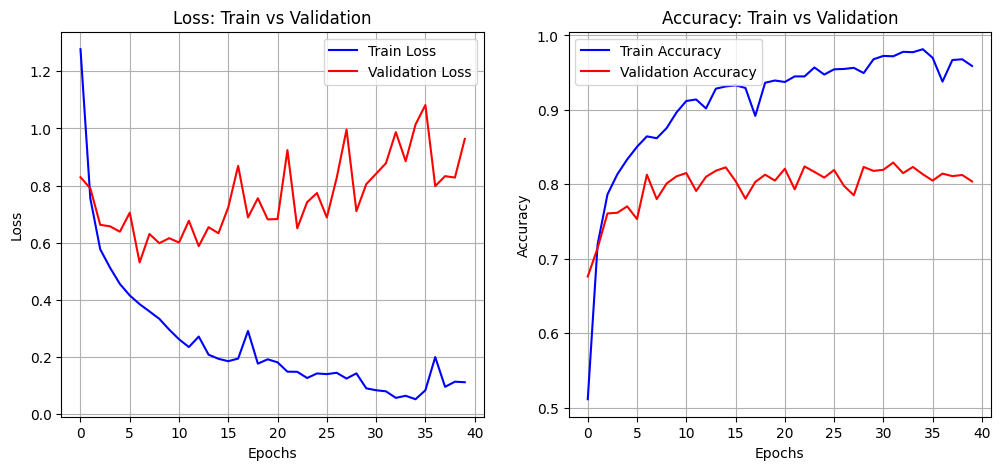

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Урезаем датасет
subset_indices = list(range(0, 2000))
train_subset = torch.utils.data.Subset(fmnist_dataset_train, subset_indices)

overfit_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)

hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []

num_epochs = 40

for epoch in range(num_epochs):
    # Train
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in overfit_loader:
        images, labels = images.to(device), labels.to(device)

        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        total_loss += loss.item()

        #  точность на трейне
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(overfit_loader)
    train_acc = correct_train / total_train

    # 2. Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_acc = correct_val / total_val

    hist_train_loss.append(avg_train_loss)
    hist_val_loss.append(avg_val_loss)
    hist_train_acc.append(train_acc)
    hist_val_acc.append(val_acc)

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')

# ГРАФИКИ
plt.figure(figsize=(12, 5))

#  Loss
plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Train Loss', color='blue')
plt.plot(hist_val_loss, label='Validation Loss', color='red')
plt.title('Loss: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

#  Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_train_acc, label='Train Accuracy', color='blue')
plt.plot(hist_val_acc, label='Validation Accuracy', color='red')
plt.title('Accuracy: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),



            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                 [-1, 1024]       1,049,600
       BatchNorm1d-7                 [-1, 1024]           2,048
              ReLU-8                 [-1, 1024]               0
           Dropout-9                 [-1, 1024]               0
           Linear-10                  [-1, 512]         524,800
      BatchNorm1d-11                  [-1, 512]           1,024
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

Epoch [5/40] | Train Loss: 0.4346 | Val Loss: 0.5727 | Train Acc: 0.8445 | Val Acc: 0.7924
Epoch [10/40] | Train Loss: 0.3420 | Val Loss: 0.5470 | Train Acc: 0.8820 | Val Acc: 0.8177
Epoch [15/40] | Train Loss: 0.2634 | Val Loss: 0.6090 | Train Acc: 0.9070 | Val Acc: 0.8047
Epoch [20/40] | Train Loss: 0.2565 | Val Loss: 0.5985 | Train Acc: 0.9045 | Val Acc: 0.8130
Epoch [25/40] | Train Loss: 0.1726 | Val Loss: 0.7083 | Train Acc: 0.9330 | Val Acc: 0.8062
Epoch [30/40] | Train Loss: 0.2062 | Val Loss: 0.6464 | Train Acc: 0.9355 | Val Acc: 0.8240
Epoch [35/40] | Train Loss: 0.1414 | Val Loss: 0.6771 | Train Acc: 0.9525 | Val Acc: 0.8211
Epoch [40/40] | Train Loss: 0.1384 | Val Loss: 0.7714 | Train Acc: 0.9530 | Val Acc: 0.8097


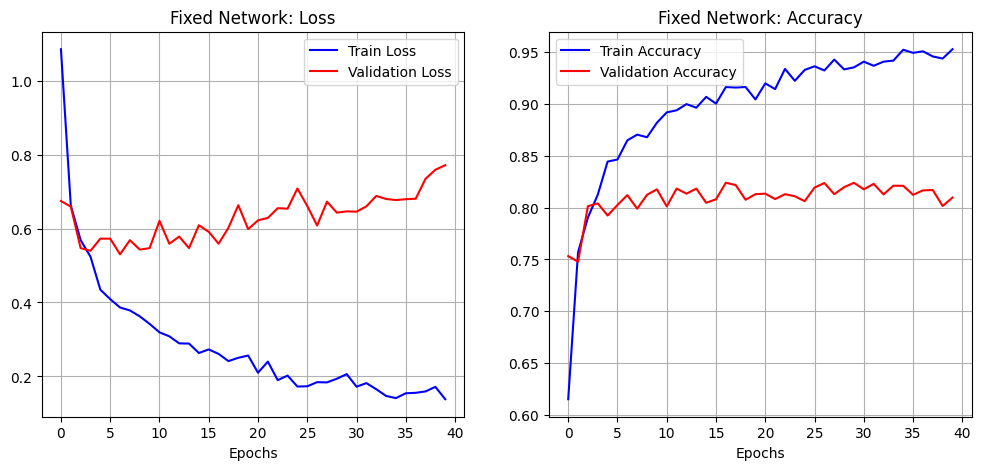

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()


hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []

num_epochs = 40

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in overfit_loader:
        images, labels = images.to(device), labels.to(device)

        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(overfit_loader)
    train_acc = correct_train / total_train

    #  Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_acc = correct_val / total_val

    hist_train_loss.append(avg_train_loss)
    hist_val_loss.append(avg_val_loss)
    hist_train_acc.append(train_acc)
    hist_val_acc.append(val_acc)

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')

# Графики
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Train Loss', color='blue')
plt.plot(hist_val_loss, label='Validation Loss', color='red')
plt.title('Fixed Network: Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_train_acc, label='Train Accuracy', color='blue')
plt.plot(hist_val_acc, label='Validation Accuracy', color='red')
plt.title('Fixed Network: Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

# **Task 2**
 Чтобы переобучить модель сократил резко объяем обучающей выборки до 2 тысяч изображений. А также увеличил количество парметров (слои 1024-1024-512, 2+млн параметров).

*   В итоге на Train Loss упал 0.1116 , а Validation Loss на пике был 1.0136 .

*   Точность тоже типична для переобученной модели:  на трейне 96.5%, на валидации чуть меньше 80%.

*   Generalization Gap составляет ≈ 16.6%, сигнал сильного переобучения.

# **Task 3**


Для чистоты эксперимента обучение велось на том же урезанном датасете (2000 изображений).
Чтобы пофиксить, насколько возможно, переобучение, добавил:
Dropout (p=0.5), чтобы побороть ко-адаптацию
и BatchNorm  -- стандартизировал данные между слоями, плюс за счёт шума (в оценке среднего и дисперсии) получил эффект регуляризации.

* Loss: к 40-й эпохе Validation Loss составил 0.77. Рост ошибки замедлился!
* Accuracy: Точность на валидации выросла до 81.0%. При этом точность на трейне росла медленнее (95.3%), что говорит о том, что Dropout мешал сети просто запоминать примеры.
* Получилось сократить ошибку на тестовых данных примерно на 25% (снижение Loss с 1.02 до 0.77).
